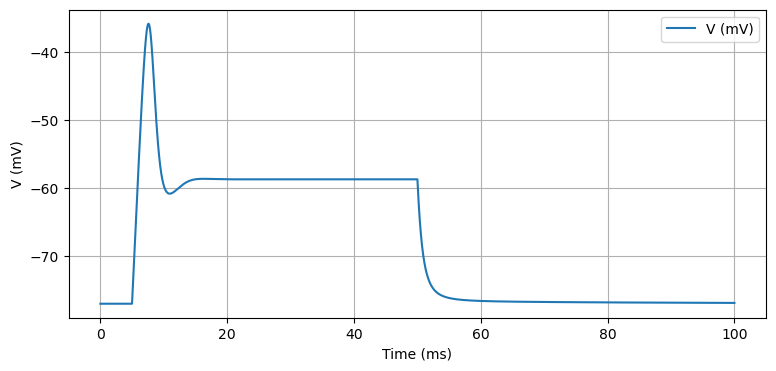

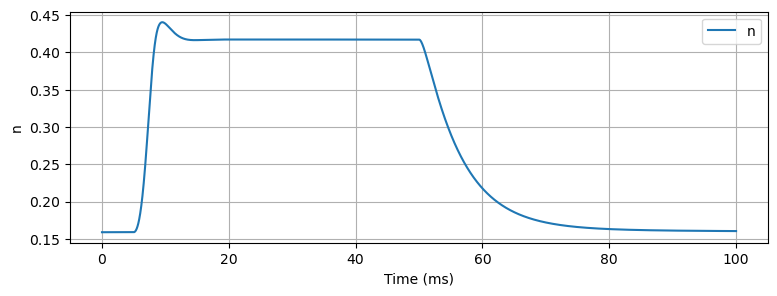

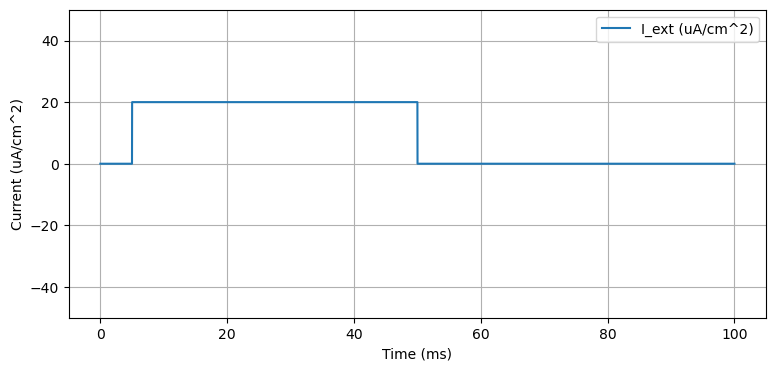

In [1]:
"""

HH model considering time and voltage depecdence of potassium conductance only and the membrane capacitance

"""


import numpy as np
import matplotlib.pyplot as plt

# Parameters 
Cm = 1.0            # µF/cm^2
g_K  = 36.0         # mS/cm^2
E_K  = -77.0        # mV
V_rest = E_K        # you set this

# time steps
t_max = 100.0
dt = 0.01
t = np.arange(0.0, t_max + dt, dt)

# injected current
I_ext = np.zeros_like(t)
I_ext[(t >= 5) & (t <= 50.0)] = 20.0

# potassium gating variable (n)
def alpha_n(V):
    x = V + 55.0
    if abs(x) < 1e-6:  # detect singularity near V = -55
        return 0.1      # correct limiting value
    else:
        return 0.01 * x / (1.0 - np.exp(-x / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

# derivative functions for coupled system
def dV_dt(V, n, I_e):
    I_k = g_K * n**4 * (V - E_K)
    return (I_e - I_k) / Cm

def dn_dt(V, n):
    a = alpha_n(V)
    b = beta_n(V)
    return a * (1.0 - n) - b * n

# initial steady-state n at V_rest
a0 = alpha_n(V_rest)
b0 = beta_n(V_rest)
n0 = a0 / (a0 + b0)

V = np.zeros_like(t)
n = np.zeros_like(t)
Ik = np.zeros_like(t)

V[0] = V_rest
n[0] = n0
Ik[0] = g_K * n0**4 * (V_rest - E_K)

# Fully coupled RK4 for [V, n]
for i in range(1, len(t)):
    Vi = V[i-1]; ni = n[i-1]; Ie = I_ext[i-1]

    # k1
    k1_V = dV_dt(Vi, ni, Ie)
    k1_n = dn_dt(Vi, ni)

    # k2 (evaluate at half step)
    V_half = Vi + 0.5 * dt * k1_V
    n_half = ni + 0.5 * dt * k1_n
    Ie_half = 0.5 * (Ie + I_ext[i])  # simple mid-point for I_ext
    k2_V = dV_dt(V_half, n_half, Ie_half)
    k2_n = dn_dt(V_half, n_half)

    # k3
    V_half = Vi + 0.5 * dt * k2_V
    n_half = ni + 0.5 * dt * k2_n
    k3_V = dV_dt(V_half, n_half, Ie_half)
    k3_n = dn_dt(V_half, n_half)

    # k4
    V_full = Vi + dt * k3_V
    n_full = ni + dt * k3_n
    k4_V = dV_dt(V_full, n_full, I_ext[i])
    k4_n = dn_dt(V_full, n_full)

    V[i] = Vi + (dt / 6.0) * (k1_V + 2*k2_V + 2*k3_V + k4_V)
    n[i] = ni + (dt / 6.0) * (k1_n + 2*k2_n + 2*k3_n + k4_n)

    Ik[i] = g_K * n[i]**4 * (V[i] - E_K)

# plotting (V, n, I_ext & I_k)
plt.figure(figsize=(9,4))
plt.plot(t, V, label='V (mV)')
plt.xlabel('Time (ms)'); plt.ylabel('V (mV)'); plt.legend(); plt.grid(True)

plt.figure(figsize=(9,3))
plt.plot(t, n, label='n')
plt.xlabel('Time (ms)'); plt.ylabel('n'); plt.legend(); plt.grid(True)

plt.figure(figsize=(9,4))
plt.plot(t, I_ext, label='I_ext (uA/cm^2)')
plt.xlabel('Time (ms)'); plt.ylabel('Current (uA/cm^2)')
plt.legend(); plt.grid(True)
plt.ylim(-50, 50)
plt.show()

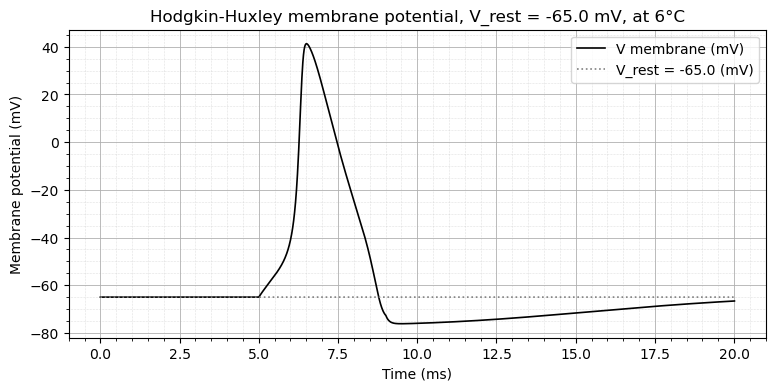

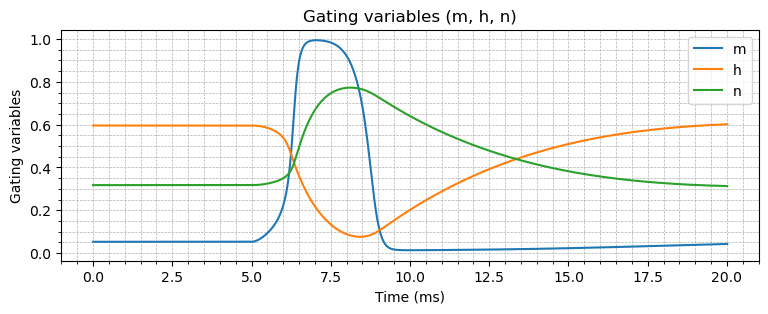

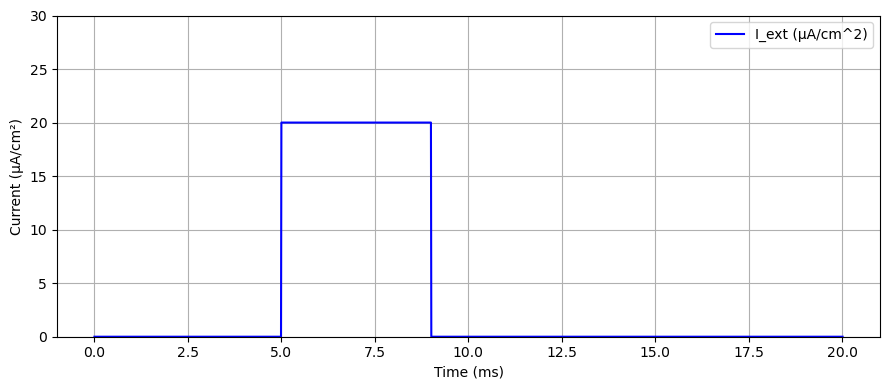

In [3]:
"""
Complete Hodgkin-Huxley model simulation (classic 1952 HH formulation).
- Variables: V (mV), m, h, n (gating variables)
- Units: time in ms, voltage in mV, conductances in mS/cm^2, Cm in uF/cm^2,
         currents in µA/cm^2 (so electrophysiology community units).
- Integration: classical RK4 for the 4 ODE system.
- Produces plots: V(t), gating variables, and ionic currents.
"""

import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Model parameters (classic)
# -------------------------
Cm = 1.0            # µF/cm^2 (membrane capacitance)
g_Na = 120.0        # mS/cm^2
g_K  = 36.0         # mS/cm^2
g_L  = 0.3          # mS/cm^2

E_Na = 50.0         # mV
E_K  = -77.0        # mV
E_L  = -54.387      # mV

# -------------------------
# Simulation settings
# -------------------------
t_max = 20.0        # ms
dt = 0.01           # ms
t = np.arange(0.0, t_max + dt, dt)
n_steps = len(t)

# External (injected) current (µA/cm^2)
I_ext = np.zeros_like(t)
I_ext[(t >= 5) & (t <= 9.0)] = 20.0

# -------------------------
# Gating variable rate functions
# Input: voltage V in mV
# -------------------------
def alpha_n(V):
    x = V + 55.0
    if abs(x) < 1e-6:  # detect singularity near V = -55
        return 0.1      # correct limiting value
    else:
        return 0.01 * x / (1.0 - np.exp(- x / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

def alpha_m(V):
    x = V + 40.0
    if abs(x) < 1e-6:   # detect singularity near V = -40
        return 0.1*10
    else:
        return 0.1 * x / (1.0 - np.exp(- x / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))


# -------------------------
# RHS of the ODE system
# State vector y = [V, m, h, n]
# returns dy/dt
# -------------------------
def hh_rhs(y, I_inj):
    V, m, h, n = y
    
    a_m = alpha_m(V)
    b_m = beta_m(V)
    a_h = alpha_h(V)
    b_h = beta_h(V)
    a_n = alpha_n(V)
    b_n = beta_n(V)

    # gating derivatives
    dm_dt = a_m * (1.0 - m) - b_m * m
    dh_dt = a_h * (1.0 - h) - b_h * h
    dn_dt = a_n * (1.0 - n) - b_n * n

    # ionic currents (µA/cm^2)
    I_Na = g_Na * (m**3) * h * (V - E_Na)
    I_K  = g_K  * (n**4) * (V - E_K)
    I_L  = g_L  * (V - E_L)

    # dV/dt (mV/ms)  (I_inj - sum(ionic currents)) / Cm
    dV_dt = (I_inj - I_Na - I_K - I_L) / Cm

    return np.array([dV_dt, dm_dt, dh_dt, dn_dt]), I_Na, I_K, I_L

# -------------------------
# Initial conditions at rest (used steady-state for gating at V_rest = -65 mV)
# -------------------------
V_rest = -65.0
V_rest_arr = np.zeros_like(t)
for i in range(len(t)):
    V_rest_arr[i]= V_rest
    
    
    
a_m0 = alpha_m(V_rest)
b_m0 = beta_m(V_rest)
a_h0 = alpha_h(V_rest)
b_h0 = beta_h(V_rest)
a_n0 = alpha_n(V_rest)
b_n0 = beta_n(V_rest)

m0 = a_m0 / (a_m0 + b_m0)
h0 = a_h0 / (a_h0 + b_h0)
n0 = a_n0 / (a_n0 + b_n0)

y = np.zeros((n_steps, 4))   # columns: V, m, h, n
I_Na_arr = np.zeros(n_steps)
I_K_arr  = np.zeros(n_steps)
I_L_arr  = np.zeros(n_steps)

y[0, :] = [V_rest, m0, h0, n0]

# -------------------------
# Integrate with RK4
# -------------------------
for i in range(1, n_steps):
    Inow = I_ext[i-1]

    # RK4 stage 1
    k1, I_Na1, I_K1, I_L1 = hh_rhs(y[i-1, :], Inow)
    # stage 2
    k2, _, _, _ = hh_rhs(y[i-1, :] + 0.5 * dt * k1, Inow)
    # stage 3
    k3, _, _, _ = hh_rhs(y[i-1, :] + 0.5 * dt * k2, Inow)
    # stage 4
    k4, _, _, _ = hh_rhs(y[i-1, :] + dt * k3, Inow)

    y[i, :] = y[i-1, :] + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

    # compute currents for logging at the new state (optional: use hh_rhs)
    _, I_Na_arr[i], I_K_arr[i], I_L_arr[i] = hh_rhs(y[i, :], I_ext[i])

# -------------------------
# Extract solutions
# -------------------------
V = y[:, 0]
m = y[:, 1]
h = y[:, 2]
n = y[:, 3]

# -------------------------
# Plots 
# -------------------------

# Voltage
plt.figure(figsize=(9, 4))
plt.plot(t, V, color='k', lw=1.2, label='V membrane (mV)')
plt.plot(t, V_rest_arr, color='gray', linestyle=':', linewidth=1.2, label='V_rest = {:.1f} (mV)'.format(V_rest))
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title(f'Hodgkin-Huxley membrane potential, V_rest = {V_rest:.1f} mV, at 6°C')
plt.legend(loc='upper right')
plt.grid(which='major', linestyle='-', linewidth=0.6)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.7)

# Gating variables
plt.figure(figsize=(9, 3))
plt.plot(t, m, label='m')
plt.plot(t, h, label='h')
plt.plot(t, n, label='n')
plt.xlabel('Time (ms)')
plt.ylabel('Gating variables')
plt.title('Gating variables (m, h, n)')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

# Ionic currents
plt.figure(figsize=(9, 4))
plt.plot(t, I_ext,  label='I_ext (µA/cm^2)', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Current (µA/cm²)')
plt.legend()
plt.grid()

plt.ylim(0, 30)
plt.tight_layout()
plt.show()